In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
from scipy import stats
from imblearn.over_sampling import SMOTE
#import the data and remove extra index columns
admision= pd.read_csv('admission.csv', delimiter= ';')
admision= admision.drop(['Unnamed: 0'], axis=1)
datasignal = pd.read_csv('signal.csv', delimiter= ';')
datasignal= datasignal.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)
age=pd.read_csv('age.csv', delimiter= ';')
age= age.drop(['Unnamed: 0'], axis=1)

ModuleNotFoundError: No module named 'imblearn'

In [2]:
#The 3 signal parameters are all in the same column and their values are in a values column. We make 3 different columns for the
# 3 parameters.
datasignal.pivot(index=None, columns='parameter', values='value')
data=pd.merge(datasignal, datasignal.pivot(index=None, columns='parameter', values='value'), left_index= True, right_index= True)
data= data.drop(['parameter', 'value'], axis=1) #drop the original columns

In [3]:
# remove outliers. Everything that is above 3 starndard deviations from the column mean.

means= data['respiration_rate'].mean()
stds= data['respiration_rate'].std()

data['respiration_rate']= data['respiration_rate'].where(np.abs((data['respiration_rate']-means)/stds)<3, np.NaN)
means= data['blood_pressure'].mean()
stds= data['blood_pressure'].std()

data['blood_pressure']= data['blood_pressure'].where(np.abs((data['blood_pressure']-means)/stds)<3, np.NaN)

means= data['temperature'].mean()
stds= data['temperature'].std()

data['temperature']= data['temperature'].where(np.abs((data['temperature']-means)/stds)<3, np.NaN)

In [4]:
data= data.dropna(axis=0, how='all') #remove rows that have no measurements

In [5]:
df_data = pd.DataFrame(data.groupby(['pat_id','day'])['blood_pressure','respiration_rate','temperature'].mean())
df_data.columns = ['blood_pressure_mean','respiration_rate_mean','temperature_mean']
df_data.reset_index(drop=False,inplace=True)


In [6]:
df_data2 = pd.DataFrame(data.groupby(['pat_id','day'])['blood_pressure','respiration_rate','temperature'].std())
df_data2.columns = ['blood_pressure_std','respiration_rate_std','temperature_std']
df_data2.reset_index(drop=False,inplace=True)

In [7]:
df_data3 = pd.DataFrame(data.groupby(['pat_id','day'])['blood_pressure','respiration_rate','temperature'].max())
df_data3.columns = ['blood_pressure_max','respiration_rate_max','temperature_max']
df_data3.reset_index(drop=False,inplace=True)

In [8]:
df_data4 = pd.DataFrame(data.groupby(['pat_id','day'])['blood_pressure','respiration_rate','temperature'].min())
df_data4.columns = ['blood_pressure_min','respiration_rate_min','temperature_min']
df_data4.reset_index(drop=False,inplace=True)

In [9]:
data=pd.merge(df_data, df_data2, on=['pat_id','day'])
data=pd.merge(data, df_data3, on=['pat_id','day'])
data=pd.merge(data, df_data4, on=['pat_id','day'])
data['day']= pd.to_datetime(data['day'])
del [df_data, df_data4,df_data3,df_data2]
#del [df_data, df_data3,df_data2]
gc.collect()

119

In [10]:
data['respiration_rate_min']=data['respiration_rate_min'].where(data['respiration_rate_min']>1, np.NaN)
data['respiration_rate_max']=data['respiration_rate_max'].where(data['respiration_rate_max']>1, np.NaN)
data['respiration_rate_mean']=data['respiration_rate_std'].where(data['respiration_rate_std']>0, np.NaN)
data['respiration_rate_mean']=data['respiration_rate_mean'].where(data['respiration_rate_mean']>1, np.NaN)

In [11]:
data.isnull().sum()

pat_id                      0
day                         0
blood_pressure_mean       272
respiration_rate_mean    2698
temperature_mean         1886
blood_pressure_std        317
respiration_rate_std     1287
temperature_std          2720
blood_pressure_max        272
respiration_rate_max     1171
temperature_max          1886
blood_pressure_min        272
respiration_rate_min     1529
temperature_min          1886
dtype: int64

In [12]:
data= data.fillna(data.mean())



In [13]:
#shift the data features to add the vitals of the previous day
data[['blood_pressure_mean-', 'respiration_rate_mean-',
       'temperature_mean-', 'blood_pressure_std-', 'respiration_rate_std-',
       'temperature_std-', 'blood_pressure_max-', 'respiration_rate_max-',
       'temperature_max-', 'blood_pressure_min-', 'respiration_rate_min-',
       'temperature_min-']]= data[['blood_pressure_mean', 'respiration_rate_mean',
       'temperature_mean', 'blood_pressure_std', 'respiration_rate_std',
       'temperature_std', 'blood_pressure_max', 'respiration_rate_max',
       'temperature_max', 'blood_pressure_min', 'respiration_rate_min',
       'temperature_min']].shift(1)

# remove shifted values that come from different patient ids
data.loc[data.pat_id != data.pat_id.shift(1), ['blood_pressure_mean-', 'respiration_rate_mean-',
       'temperature_mean-', 'blood_pressure_std-', 'respiration_rate_std-',
       'temperature_std-', 'blood_pressure_max-', 'respiration_rate_max-',
       'temperature_max-', 'blood_pressure_min-', 'respiration_rate_min-',
       'temperature_min-']] = None

In [13]:
#create labels of good and bad discharges from the admision file

admision= pd.read_csv('admission.csv', delimiter= ';')
admision= admision.drop(['Unnamed: 0'], axis=1)
admision=admision.sort_values(by=['pat_id', 'date_admission'])
admision.reset_index(drop=False,inplace=True)
admision['date_discharge']= pd.to_datetime(admision['date_discharge'])
admision['date_admission']= pd.to_datetime(admision['date_admission'])
new_column= admision.groupby(['pat_id']).apply(lambda x: x['date_admission'].shift(-1)- x['date_discharge'])
admision['diff'] = new_column.reset_index(level=0, drop=True)
admision['diff']= admision['diff'].dt.days
admision['diff']= admision['diff'].where(admision['diff']<10, np.NaN)
admision['label']= admision['diff'].fillna(0)
admision['label']= admision['label'].where(admision['label']< 1 , other= 1)
admision= admision.drop(['date_admission', 'index', 'diff'], axis=1)
admision= admision.rename(index=str, columns={"date_discharge": "day"})
admision.head()

,pat_id,day,label
0,0,2016-01-07,0.0
1,1,2014-07-06,0.0
2,3,2014-10-20,0.0
3,4,2015-02-07,0.0
4,5,2014-12-08,0.0


In [14]:
#merge data
data = pd.merge(data, age, on=['pat_id'])

data = pd.merge(data, admision, on=['pat_id', 'day' ])
data= data.fillna(data.mean())
data.head()

,pat_id,day,blood_pressure_mean,respiration_rate_mean,temperature_mean,blood_pressure_std,respiration_rate_std,temperature_std,blood_pressure_max,respiration_rate_max,temperature_max,blood_pressure_min,respiration_rate_min,temperature_min,age,label
0,0,2016-01-07,129.798553,2.570740,35.746152,4.752183,0.008944,0.358990,136.966170,2.010000,35.999996,123.533170,1.990,35.492307,35.0,0.0
1,1,2014-07-06,132.951555,2.570740,37.772648,8.235665,1.520943,0.258115,144.900166,9.863428,38.046153,119.001003,7.068,37.533332,77.0,0.0
2,3,2014-10-20,107.502751,1.432541,37.333332,10.852083,1.432541,0.381695,127.835003,8.000000,37.333332,96.600333,4.000,37.333332,61.0,0.0
3,4,2015-02-07,120.313955,1.044508,37.314953,9.181572,1.044508,0.381695,138.566004,6.010000,37.563998,107.733502,3.990,37.059614,27.0,0.0
4,5,2014-12-08,160.832146,1.038141,36.920515,28.838446,1.038141,0.003626,194.508832,10.010000,36.923079,118.033901,7.990,36.917950,67.0,0.0


In [39]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

In [40]:

lb = preprocessing.LabelBinarizer()
binary_labels=lb.fit_transform(data['label'])
binary_labels.shape
binary_labels=np.reshape(binary_labels,(1479,))

In [468]:
data2= data.drop(['pat_id', 'day', 'label'], axis=1)
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(data2, binary_labels, test_size=0.1)

#X_train, X_test, y_train, y_test = train_test_split(data2[['blood_pressure_max', 'temperature_max','respiration_rate_mean']], binary_labels, test_size=0.2)

In [469]:
smote = SMOTE(ratio='minority',random_state=0)
X_train, y_train= smote.fit_sample(X_train, y_train)

In [470]:
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.feature_selection import SelectFromModel
clf=GradientBoostingClassifier( learning_rate=0.01, n_estimators=1000, subsample=1.0, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=5, random_state=0)
#clf = ExtraTreesClassifier(n_estimators=1000, min_samples_split=2, random_state=0)
clf = clf.fit(X_train,y_train)
clf.feature_importances_ 

array([0.0356568 , 0.04697791, 0.01002334, 0.03139379, 0.0892955 ,
       0.07610943, 0.09263684, 0.07625979, 0.11062767, 0.0956083 ,
       0.18315453, 0.1184369 , 0.03381919])

In [471]:
model = SelectFromModel(clf, prefit=True)
X_train = model.transform(X_train)
X_test = model.transform(X_test)
X_train.shape 

(2600, 6)

In [472]:
clf=GradientBoostingClassifier( learning_rate=0.01, n_estimators=1000, subsample=1.0, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=5, random_state=0) 

In [473]:
clf= clf.fit(X_train, y_train)

In [474]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       145
           1       0.00      0.00      0.00         3

   micro avg       0.96      0.96      0.96       148
   macro avg       0.49      0.49      0.49       148
weighted avg       0.96      0.96      0.96       148



In [475]:
np.mean(cross_val_score(clf, X_train, y_train, cv=5))

0.9773076923076923

In [476]:
gnb = GaussianNB()

In [477]:
gnb = gnb.fit(X_train, y_train)


In [478]:
y_pred = gnb.predict(X_test)

In [479]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.54      0.69       145
           1       0.01      0.33      0.03         3

   micro avg       0.53      0.53      0.53       148
   macro avg       0.49      0.44      0.36       148
weighted avg       0.96      0.53      0.68       148



In [480]:
np.mean(cross_val_score(clf, X_train, y_train, cv=5))

0.9773076923076923

In [481]:

lf = LogisticRegression(random_state=0, solver='liblinear',class_weight ={0: 1, 1: 1}, max_iter=100)


In [482]:
lf = lf.fit(X_train, y_train)

y_pred = lf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.51      0.67       145
           1       0.03      0.67      0.05         3

   micro avg       0.51      0.51      0.51       148
   macro avg       0.51      0.59      0.36       148
weighted avg       0.97      0.51      0.66       148



In [483]:
np.mean(cross_val_score(clf, X_train, y_train, cv=5))

0.9773076923076923

In [484]:
from sklearn import tree





dt=tree.DecisionTreeClassifier( random_state =0)


dt.fit(X_train,y_train)
test = dt.predict(X_test)
test_prob = dt.predict_proba(X_test)
print(classification_report(y_test,test ))

              precision    recall  f1-score   support

           0       0.98      0.92      0.95       145
           1       0.00      0.00      0.00         3

   micro avg       0.91      0.91      0.91       148
   macro avg       0.49      0.46      0.48       148
weighted avg       0.96      0.91      0.93       148



In [485]:
np.mean(cross_val_score(clf, X_train, y_train, cv=5))

0.9773076923076923

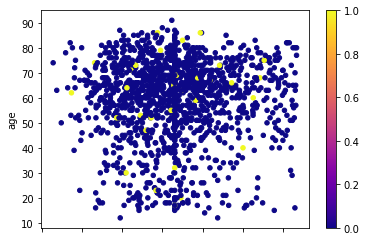

In [27]:
data.plot.scatter('blood_pressure_max', 'age', c=data.label,cmap='plasma')
plt.show()

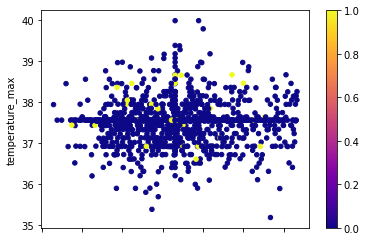

In [28]:
data.plot.scatter('blood_pressure_max', 'temperature_max', c=data.label,cmap='plasma')
plt.show()

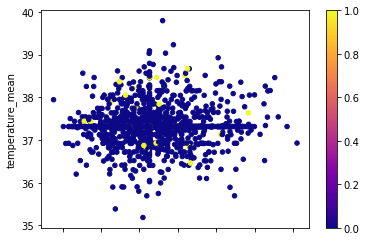

In [30]:
data.plot.scatter('blood_pressure_mean', 'temperature_mean',  c=data.label,cmap='plasma')
plt.show()

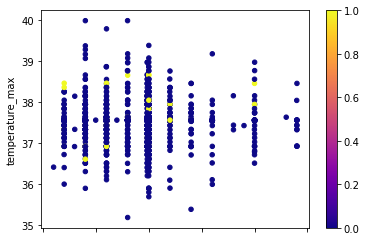

In [32]:
data.plot.scatter('respiration_rate_max', 'temperature_max',  c=data.label,cmap='plasma')
plt.show()

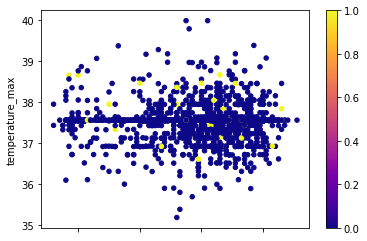

In [35]:
data.plot.scatter('age', 'temperature_max',  c=data.label,cmap='plasma')
plt.show()

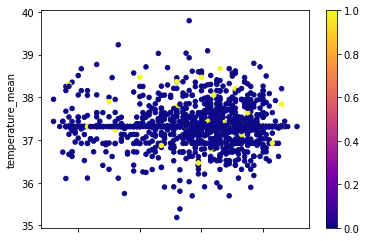

In [37]:
data.plot.scatter('age', 'temperature_mean',  c=data.label,cmap='plasma')
plt.show()

In [486]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=2,weights= 'distance')



In [487]:
np.mean(cross_val_score(neigh, X_train, y_train, cv=5))




0.8746153846153846

In [488]:
neigh= neigh.fit( X_train, y_train)

pred=neigh.predict(X_test)
print(classification_report(y_test,pred ))

              precision    recall  f1-score   support

           0       0.98      0.84      0.91       145
           1       0.04      0.33      0.07         3

   micro avg       0.83      0.83      0.83       148
   macro avg       0.51      0.59      0.49       148
weighted avg       0.96      0.83      0.89       148



In [404]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from itertools import product
from sklearn.ensemble import VotingClassifier

In [ ]:
clf1 = DecisionTreeClassifier(max_depth=4)
clf2 = KNeighborsClassifier(n_neighbors=2,weights= 'distance')
clf3 = SVC(gamma='scale', kernel='rbf', probability=True)
eclf = VotingClassifier(estimators=[('dt', clf1), ('knn', clf2), ('svc', clf3)], voting='soft', weights=[2,1,2])